# Fitting multi-position curves from multiple files

This script uses functions and a class object defined in the fit_FCS.py file. **Make sure that the 2 files are saved in the same location !!**

The idea behind class usage is to embed in the class a number of experimental informations (concentrations, laser power, acquisition parameters...), that can be recalled afterwards.

## Table of content
- [Import Libraries and functions](#libraries)
- [Define the input and output folders](#folders)
- [Define the experimental parameters](#exp_param)
- [Define the fitting parameters](#fit_param)
- [Manually select good data](#select)
- [Fit and plot data](#fit)
- [Plot the fitted parameters](#plot)


---

---

## Import Libraries and functions <a class="anchor" id="libraries"></a>



In [1]:
import numpy as np
import pandas as pd
from numpy import loadtxt
import os
import linecache
from lmfit import Parameters, minimize


import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from fit_FCS import *
from fit_FCS import func1,func2

---
## Define the input and output folders <a class='anchor' id='folders'></a>


- Change the paths to the input folder : **this folder should contain all your folders with your experiments**. Then you need to have your data in one folder per experiment, whose name is the date of the experiment.
- Change the path of the output folder : this is the folder where all results will be stored (graphs, dataframes...)
- You can manually remove unwanted files from the analysis (in this case, uncomment the two lines and change names accordingly)



In [2]:
Folder = '/Users/christine/Documents/Data/DropInOut/FCS/Vincent/' 
OutputFolder = '/Users/christine/Documents/Data/DropInOut/FCS/Vincent/Results/'

Enter the date (which should correspond to the name of the folder where you have your data) 

In [3]:
date = '231123'
InputFolder = Folder+date+'/csv/'

files = os.listdir(InputFolder)
#files.remove('.DS_Store')

# Remove files that do not have the expected number of curves or for other reasons
#files.remove('10µW-pept_FITC600µM+arn0.5g.l_9position-time0.csv')
#files.remove('40µW-pept_FITC600µM+arn0.5g.l_9position-time0.csv')

print(files)

['10µW-pept_FITC600µM+arn0.5g.l_9position-time10.csv', '10µW-pept_FITC600µM+arn0.5g.l_9position-time15.csv', '10µW-pept_FITC600µM+arn0.5g.l_9position-time60.csv', '10µW-pept_FITC600µM+arn0.5g.l_9position-time50.csv', '10µW-pept_FITC600µM+arn0.5g.l_9position-time45.csv', '10µW-pept_FITC600µM+arn0.5g.l_9position-time0.csv', '10µW-pept_FITC600µM+arn0.5g.l_9position-time5.csv', '10µW-pept_FITC600µM+arn0.5g.l_9position-time55.csv', '10µW-pept_FITC600µM+arn0.5g.l_9position-time40.csv', '10µW-pept_FITC600µM+arn0.5g.l_9position-time30.csv', '10µW-pept_FITC600µM+arn0.5g.l_9position-time25.csv', '10µW-pept_FITC600µM+arn0.5g.l_9position-time35.csv', '10µW-pept_FITC600µM+arn0.5g.l_9position-time20.csv']


---

## Define the experimental parameters <a class='anchor' id='exp_param'></a>

- Enter the w0 and z0 obtained from the calibration
- Enter the experimental conditions


In [4]:
w0 = 0.37
Z0 = 6

exp_guy = "Vincent"
fluo = 12      # concentration of the fluorescent peptide in nM
cold = 600     # concentration of the unlabeled peptide in uM
rna = 0.5      # concentration of the RNA in mg/mL
PKA = 0        # concentration of the PKA in U
LPP = 0        # concentration of the lambda phosphatase in U
mncl2 = 0      # concentration of MnCl2 in mM
height = 1     # distance of measurement (from the coverslip)

# Enter number of species for the fit - if 2, 1 species fitting will als be performed, fit performanace will be compared.
nb = 2

# Do you want to plot the individual FCS + FIT curves (0=no / 1=yes) ?
plotcorr = 1

# Do you want to print the individual results of the fits (0=no / 1=yes) ?
printres = 0

---

## Plot data <a class='anchor' id='fit'></a>

In [5]:
curated_data = pd.read_csv(Folder+date+'/Results/'+date+'_data.csv')
curated_data

,Unnamed: 0,Filename,Nombres,Power,cps,Phase,Time,Quality
0,0,NaN,NaN,NaN,NaN,NaN,NaN,good
1,1,NaN,NaN,NaN,NaN,NaN,NaN,good
2,2,NaN,NaN,NaN,NaN,NaN,NaN,good
3,3,NaN,NaN,NaN,NaN,NaN,NaN,good
4,4,NaN,NaN,NaN,NaN,NaN,NaN,good
...,...,...,...,...,...,...,...,...
112,112,NaN,NaN,NaN,NaN,NaN,NaN,good
113,113,NaN,NaN,NaN,NaN,NaN,NaN,good
114,114,NaN,NaN,NaN,NaN,NaN,NaN,good
115,115,NaN,NaN,NaN,NaN,NaN,NaN,good


In [1]:
i=0
for filename in files:
    indices = range(9*i,9*i+10)
    quality=curated_data.iloc[indices,:].reset_index()
    i=i+1

    print(filename)
      
    data=loadtxt(InputFolder+filename, delimiter=',', skiprows=13)
    title = filename
    #time = filename.split('.')[-2].split('-')[-1]
       
    xdata = data[0,:]


    colors=[]
    pos=[]

    for k in range(1,4):
        pos.append('LD')
        colors.append('b')

    for k in range(4,7):
        pos.append('HD')
        colors.append('g')

    for k in range(7,10):
        pos.append('SF')
        colors.append('r')
    
    fig = plt.figure(figsize=(4, 7))
    gs = gridspec.GridSpec(1, 1)
    ax1 = fig.add_subplot(gs[0])
    ax1.set_title(title)
    ax1.set_xlabel('Time (s)', fontsize=14)
    ax1.set_ylabel('Correlation', fontsize=14)
    ax1.set_xscale('log')
    #ax1.set_yscale('log')
    ax1.grid(True)

    for k in range(1,10):
        if quality['Quality'][k-1]=='bad':
            pass
        else:
            ydata = data[(2*k+1),:] 
            ax1.plot(xdata, ydata,  marker='o', linestyle='None',label=pos[k-1], color=colors[k-1])                
            plt.legend()
    plt.show()
                
            #--------------------------------------------------------------
            # refine and correct assignment of curves, based on plots
    user_input = input("Are the curves correctly assigned ? (yes/no): ")

    # Process the user's response
    if user_input.lower() == 'yes':
        print("Data will not be reassigned.")
        for k in range(1,10):
            curated_data['Filename'].iloc[indices]=filename
            curated_data['Phase'].iloc[indices].iloc[k-1] = pos[k-1]
            curated_data
                

NameError: name 'files' is not defined

In [22]:
curated_data.iloc[0:10,:]

,Unnamed: 0,Filename,Nombres,Power,cps,Phase,Time,Quality
0,0,10µW-pept_FITC600µM+arn0.5g.l_9position-time10...,NaN,NaN,NaN,SF,NaN,good
1,1,10µW-pept_FITC600µM+arn0.5g.l_9position-time10...,NaN,NaN,NaN,SF,NaN,good
2,2,10µW-pept_FITC600µM+arn0.5g.l_9position-time10...,NaN,NaN,NaN,SF,NaN,good
3,3,10µW-pept_FITC600µM+arn0.5g.l_9position-time10...,NaN,NaN,NaN,SF,NaN,good
4,4,10µW-pept_FITC600µM+arn0.5g.l_9position-time10...,NaN,NaN,NaN,SF,NaN,good
5,5,10µW-pept_FITC600µM+arn0.5g.l_9position-time10...,NaN,NaN,NaN,SF,NaN,bad
6,6,10µW-pept_FITC600µM+arn0.5g.l_9position-time10...,NaN,NaN,NaN,SF,NaN,good
7,7,10µW-pept_FITC600µM+arn0.5g.l_9position-time10...,NaN,NaN,NaN,SF,NaN,good
8,8,10µW-pept_FITC600µM+arn0.5g.l_9position-time10...,NaN,NaN,NaN,SF,NaN,good
9,9,10µW-pept_FITC600µM+arn0.5g.l_9position-time10...,NaN,NaN,NaN,SF,NaN,good


In [9]:
                plt.close()
            # Continue with further analysis code here
            
            
            
        elif user_input.lower() == 'no':
            print("Data will not be kept. Exiting the script.")
            status.append('bad')
            plt.close()
            # Add code to exit or perform other actions
        else:
            user_input = input("Invalid input. Please enter 'yes' or 'no'. ")
            if user_input.lower() == 'yes':
                print("Data will be kept for further analysis.")
                status.append('good')
                plt.close()
                # Continue with further analysis code here
            elif user_input.lower() == 'no':
                print("Data will not be kept. Exiting the script.")
                status.append('bad')
                plt.close()

            else:
                pass
                
                plt.savefig(OutputFolder+date+'_'+filename+'_'+'.jpg')
                if plotcorr==0:
                    plt.close()

                # Creates the list of values for Numbers, Time, Diffusion  for 1 and 2 species
                dates.append(date)
                names.append(filename)
                nombres.append(round(N, 2))
                power.append(laser_power)
                #cps.append(counts)
                phase.append(pos[k-1])
                times.append(time)
                pop.append(nb_species)
                offset.append(Offset)
                tauds.append(round(t*1000, 3))
                tauds1.append(round(t1*1000, 3))
                tauds2.append(round(t2*1000, 3))
                difcoefs1.append(round(D1,3))
                difcoefs2.append(round(D2,3))
                fraction.append(round(F1,2))
                chi2.append(res)

print('Done !!')            
            
df = pd.DataFrame()

df['Dates']=dates
df['Filename']=names                                
df['Nombres']=nombres
df['Power']=power
#df['cps']=cps
df['Phase']=phase
df['Time']=times
df['Nb of species']=pop
df['Offset']=offset
df['tauds']=tauds
df['tauds1']=tauds1
df['tauds2']=tauds2
df['D1']=difcoefs1
df['D2']=difcoefs2
df['F1']=fraction
df['chi2']=chi2

df.to_csv(OutputFolder+'results.csv')

IndentationError: unexpected indent (1696762405.py, line 6)

10µW-pept_FITC600µM+arn0.5g.l_9position-time0.csv
10µW-pept_FITC600µM+arn0.5g.l_9position-time10.csv
10µW-pept_FITC600µM+arn0.5g.l_9position-time15.csv
10µW-pept_FITC600µM+arn0.5g.l_9position-time20.csv
10µW-pept_FITC600µM+arn0.5g.l_9position-time25.csv
10µW-pept_FITC600µM+arn0.5g.l_9position-time30.csv
10µW-pept_FITC600µM+arn0.5g.l_9position-time35.csv
10µW-pept_FITC600µM+arn0.5g.l_9position-time40.csv
10µW-pept_FITC600µM+arn0.5g.l_9position-time45.csv
10µW-pept_FITC600µM+arn0.5g.l_9position-time5.csv
10µW-pept_FITC600µM+arn0.5g.l_9position-time50.csv
10µW-pept_FITC600µM+arn0.5g.l_9position-time55.csv


IndexError: positional indexers are out-of-bounds

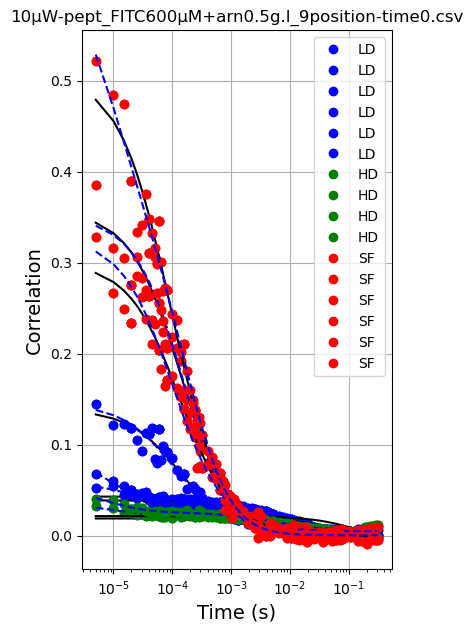

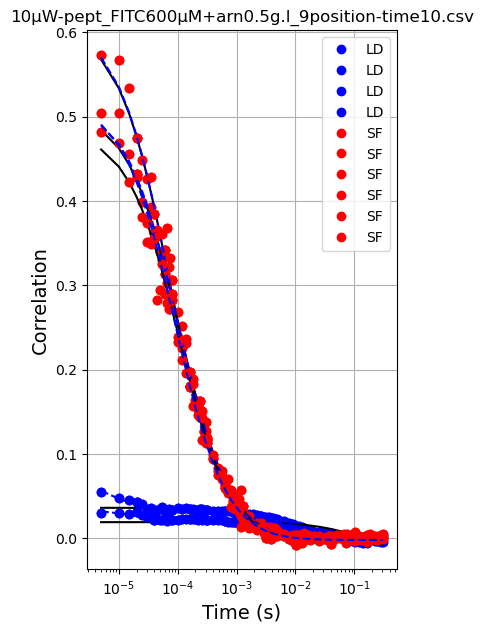

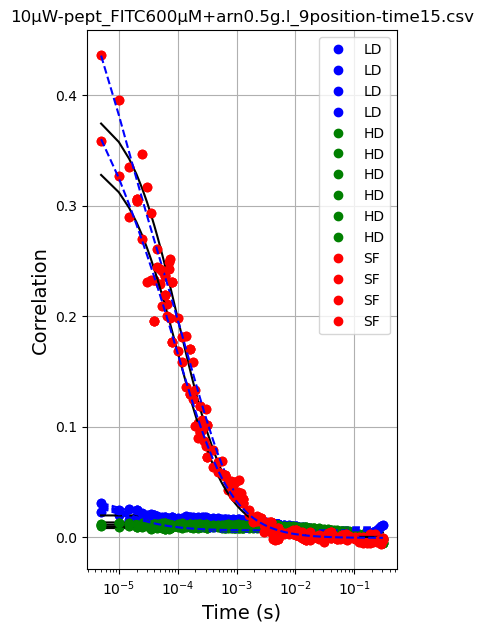

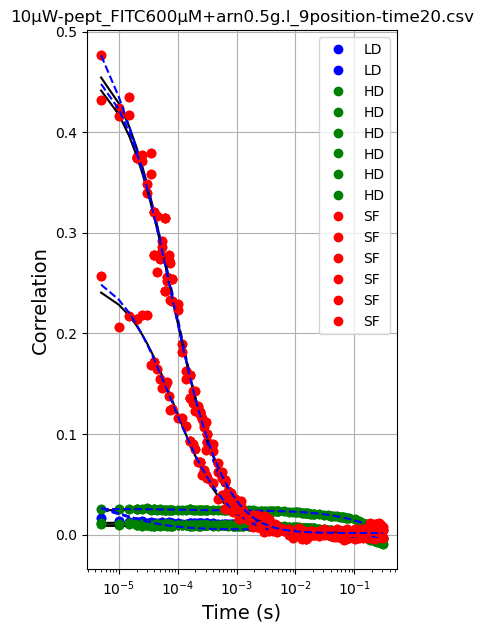

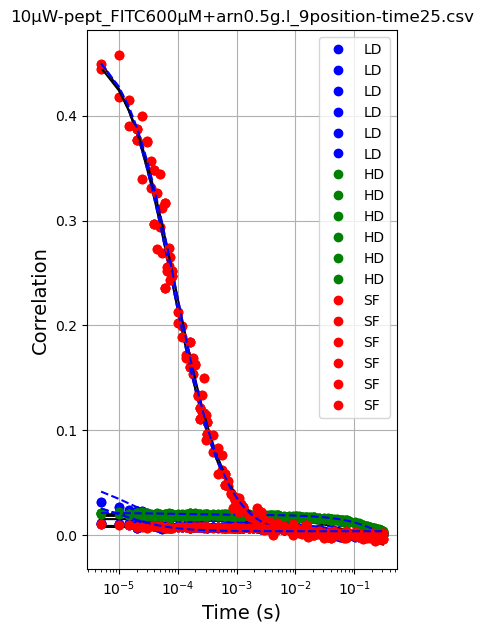

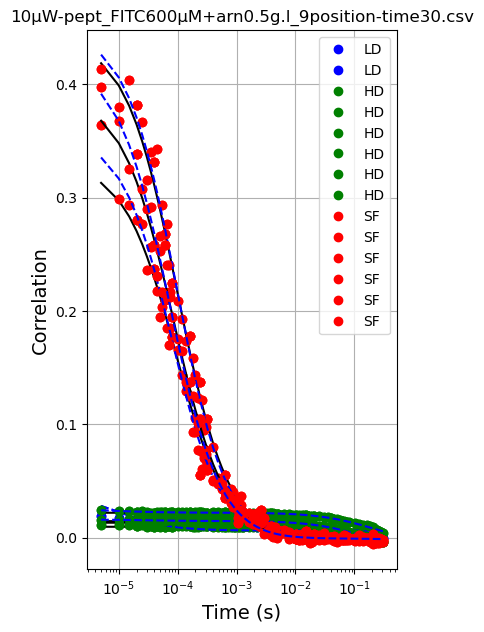

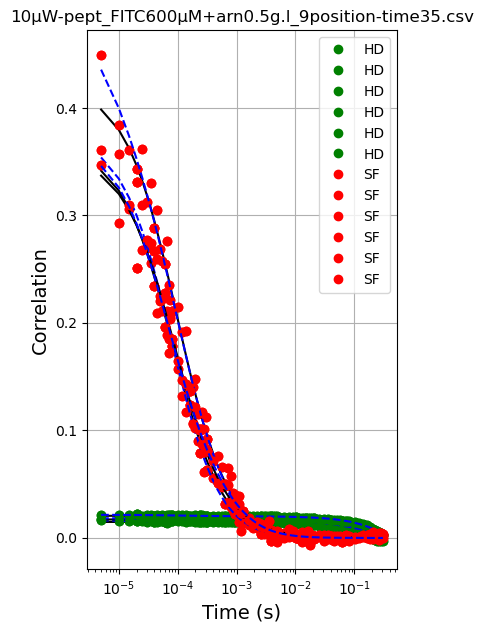

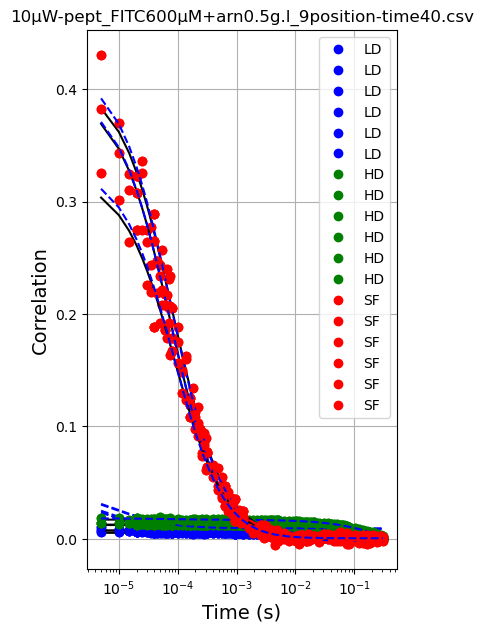

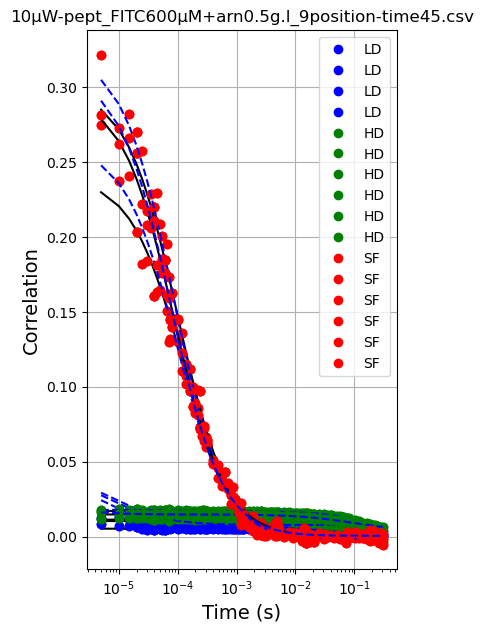

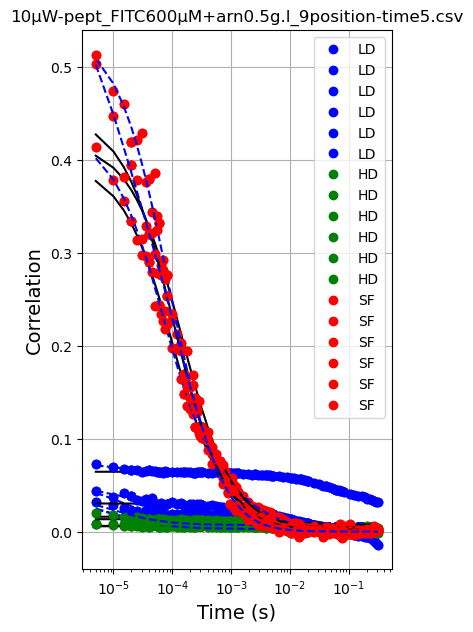

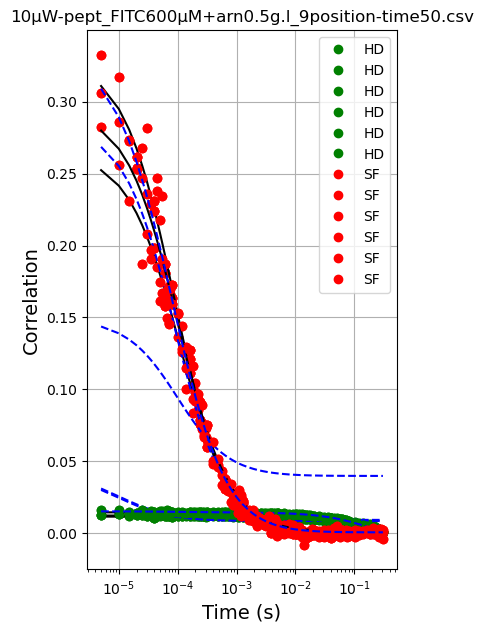

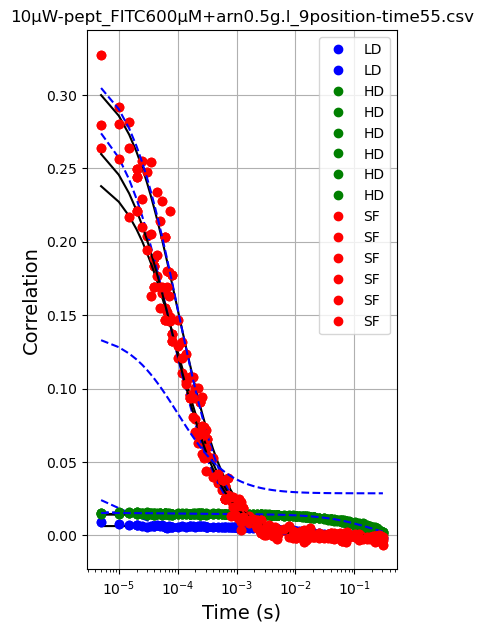

In [7]:
df = pd.DataFrame()

time=[]
for i in range(len(times)):
    time.append(int(times[i].replace('time','')))
    
    
df['Dates']=dates
df['Filename']=names                                
df['Nombres']=nombres
df['Power']=power
#df['cps']=cps
df['Phase']=phase
df['Time']=time
df['Nb of species']=pop
df['Offset']=offset
df['tauds']=tauds
df['tauds1']=tauds1
df['tauds2']=tauds2
df['D1']=difcoefs1
df['D2']=difcoefs2
df['F1']=fraction
df['chi2']=chi2

df.to_csv(OutputFolder+'results.csv')

In [8]:
df

,Dates,Filename,Nombres,Power,Phase,Time,Nb of species,Offset,tauds,tauds1,tauds2,D1,D2,F1,chi2
0,231123,10µW-pept_FITC600µM+arn0.5g.l_9position-time0.csv,26.08,10µW,LD,0,1,0.004554,4.645,NaN,NaN,7.37,NaN,1.00,0.000015
1,231123,10µW-pept_FITC600µM+arn0.5g.l_9position-time0.csv,9.87,10µW,LD,0,2,0.004509,4.645,0.010,15.578,3422.50,2.20,0.66,0.000002
2,231123,10µW-pept_FITC600µM+arn0.5g.l_9position-time0.csv,7.40,10µW,LD,0,1,0.003003,0.131,NaN,NaN,260.32,NaN,1.00,0.000041
3,231123,10µW-pept_FITC600µM+arn0.5g.l_9position-time0.csv,6.97,10µW,LD,0,2,0.001089,0.131,0.100,4.303,342.25,7.95,0.93,0.000041
4,231123,10µW-pept_FITC600µM+arn0.5g.l_9position-time0.csv,29.74,10µW,LD,0,1,0.005092,2.788,NaN,NaN,12.28,NaN,1.00,0.000015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,231123,10µW-pept_FITC600µM+arn0.5g.l_9position-time55...,2.40,10µW,SF,55,2,-0.096739,0.098,0.100,9999.661,342.25,0.00,0.77,0.000098
172,231123,10µW-pept_FITC600µM+arn0.5g.l_9position-time55...,3.99,10µW,SF,55,1,-0.000824,0.103,NaN,NaN,333.39,NaN,1.00,0.000106
173,231123,10µW-pept_FITC600µM+arn0.5g.l_9position-time55...,3.40,10µW,SF,55,2,-0.001120,0.103,0.073,9998.444,467.73,0.00,1.00,0.000049
174,231123,10µW-pept_FITC600µM+arn0.5g.l_9position-time55...,3.63,10µW,SF,55,1,-0.000016,0.083,NaN,NaN,413.58,NaN,1.00,0.000044


---

## Plot parameters <a class='anchor' id='plot'></a>


For now, we will only fit 1 component fittings.





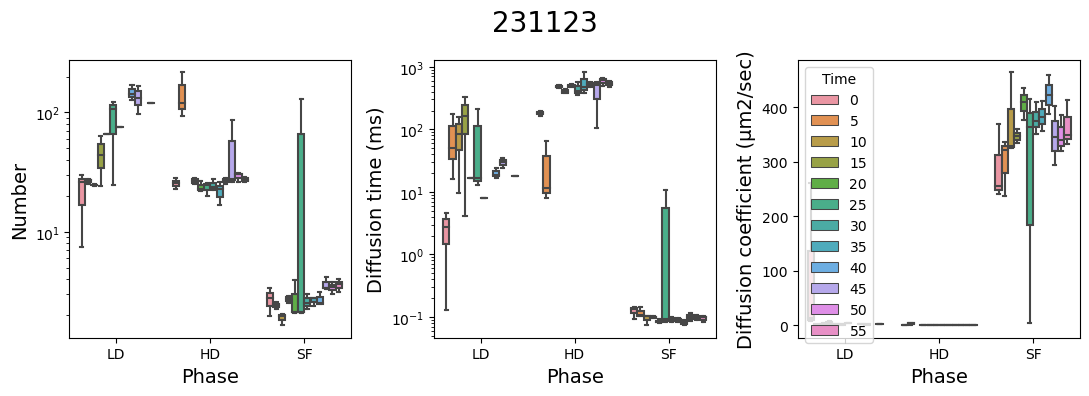

In [9]:
data = df[df['Power']=='10µW']
data1=data[data['Nb of species']==1]
data2=data[data['Nb of species']==2]

fig,axs = plt.subplots(1,3,figsize=(11,4), tight_layout=True)
fig.suptitle(date, fontsize=20)
sns.boxplot(x=data1['Phase'],y=data1['Nombres'], hue=data1['Time'],ax=axs[0])
axs[0].set_yscale('log')
axs[0].set_ylabel('Number', fontsize=14)
axs[0].set_xlabel('Phase', fontsize=14)
sns.boxplot(x=data1['Phase'],y=data1['tauds'], hue=data1['Time'],ax=axs[1])
axs[1].set_yscale('log')
axs[1].set_ylabel('Diffusion time (ms)', fontsize=14)
axs[1].set_xlabel('Phase', fontsize=14)
sns.boxplot(x=data1['Phase'],y=data1['D1'], hue=data1['Time'],ax=axs[2])
axs[2].set_ylabel('Diffusion coefficient (µm2/sec)', fontsize=14)
axs[2].set_xlabel('Phase', fontsize=14)


axs[0].legend([],frameon=False)
axs[1].legend([],frameon=False)
#axs[2].legend([],frameon=False)

plt.savefig(OutputFolder+date+'_compiled_plots_1comp.jpg')


In [ ]:
merged_data1

/var/folders/cs/qjl9__hn2ws3b7cm7jhy6c580000gn/T/ipykernel_14994/1258212690.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_data1 = data1.groupby(['Phase', 'Time']).mean().reset_index()
/var/folders/cs/qjl9__hn2ws3b7cm7jhy6c580000gn/T/ipykernel_14994/1258212690.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  std_data1 = data1.groupby(['Phase', 'Time']).std().reset_index()


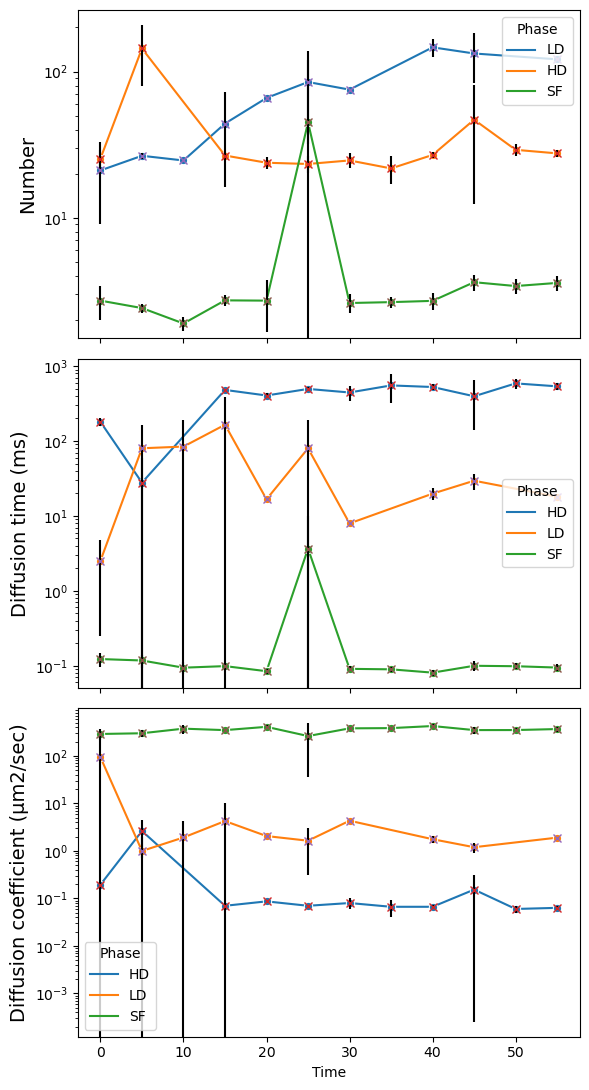

In [29]:
mean_data1 = data1.groupby(['Phase', 'Time']).mean().reset_index()
std_data1 = data1.groupby(['Phase', 'Time']).std().reset_index()
merged_data1 = pd.merge(mean_data1,std_data1,on=['Time', 'Phase'], 
                        suffixes=('_mean', '_std'))

labels=['LD','HD','SF']
palette=['b','g','r']

fig, axs = plt.subplots(3,1,figsize=(6,11), sharex=True,tight_layout=True)
sns.lineplot(data=merged_data1, x='Time', y='Nombres_mean', hue='Phase', 
             hue_order=labels, marker='o', ax=axs[0])
axs[0].set_yscale('log')
axs[0].set_ylabel('Number', fontsize=14)
plt.legend([],[],frameon=False)
sns.lineplot(data=merged_data1, x='Time', y='tauds_mean', hue='Phase', 
             marker='o',ax=axs[1])
axs[1].set_yscale('log')
axs[1].set_ylabel('Diffusion time (ms)', fontsize=14)
plt.legend([],[],frameon=False)
sns.lineplot(data=merged_data1, x='Time', y='D1_mean', hue='Phase', 
             marker='o',ax=axs[2])
axs[2].set_yscale('log')
axs[2].set_ylabel('Diffusion coefficient (µm2/sec)', fontsize=14)


# Add error bars
for phase in merged_data1['Phase'].unique():
    phase_data = merged_data1[merged_data1['Phase'] == phase]
    axs[0].errorbar(phase_data['Time'], phase_data['Nombres_mean'],
                 yerr=phase_data['Nombres_std'], fmt='x',ecolor='k')
    axs[1].errorbar(phase_data['Time'], phase_data['tauds_mean'],
                 yerr=phase_data['tauds_std'], fmt='x',ecolor='k')
    axs[2].errorbar(phase_data['Time'], phase_data['D1_mean'],
                 yerr=phase_data['D1_std'], fmt='x',ecolor='k')
    
plt.savefig(OutputFolder+'kinetic_1component.jpg')

/var/folders/cs/qjl9__hn2ws3b7cm7jhy6c580000gn/T/ipykernel_14994/1656291659.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_data2 = data2.groupby(['Phase', 'Time']).mean().reset_index()
/var/folders/cs/qjl9__hn2ws3b7cm7jhy6c580000gn/T/ipykernel_14994/1656291659.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  std_data2 = data2.groupby(['Phase', 'Time']).std().reset_index()


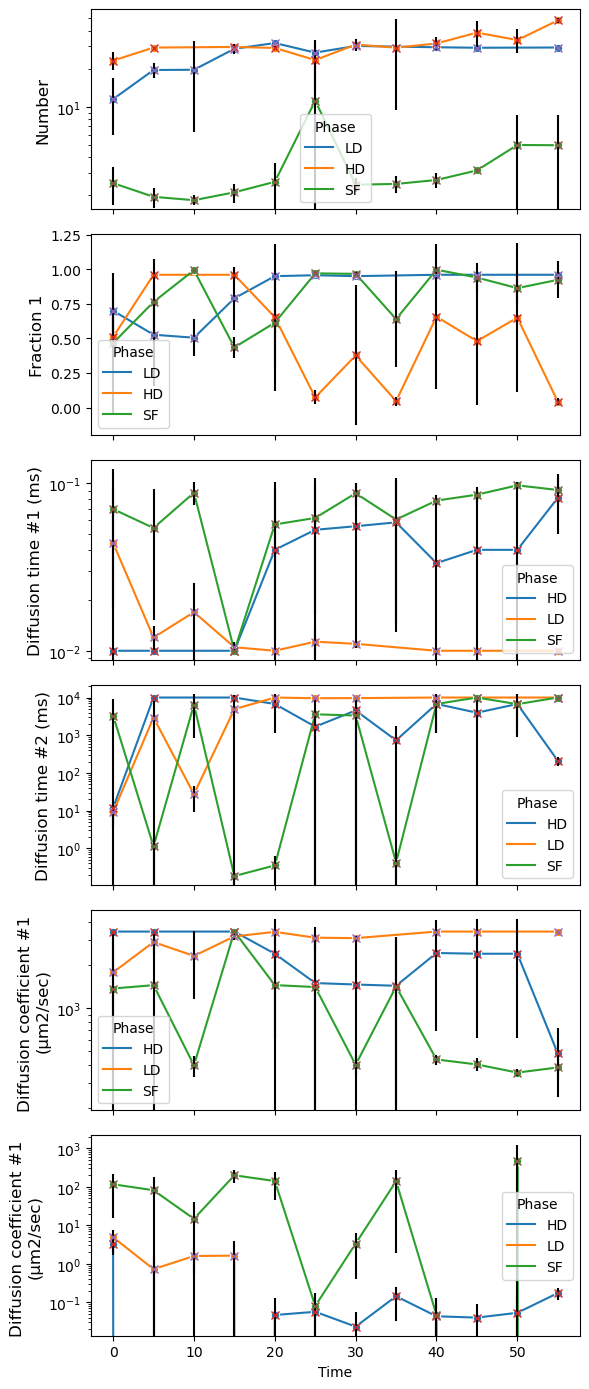

In [30]:
mean_data2 = data2.groupby(['Phase', 'Time']).mean().reset_index()
std_data2 = data2.groupby(['Phase', 'Time']).std().reset_index()
merged_data2 = pd.merge(mean_data2,std_data2,on=['Time', 'Phase'], 
                        suffixes=('_mean', '_std'))

labels=['LD','HD','SF']
palette=['b','g','r']

fig, axs = plt.subplots(6,1,figsize=(6,14), sharex=True,tight_layout=True)
sns.lineplot(data=merged_data2, x='Time', y='Nombres_mean', hue='Phase', 
             hue_order=labels, marker='o', ax=axs[0])
axs[0].set_yscale('log')
axs[0].set_ylabel('Number', fontsize=12)
#plt.legend([],[],frameon=False)

sns.lineplot(data=merged_data2, x='Time', y='F1_mean', hue='Phase', 
             hue_order=labels, marker='o', ax=axs[1])
axs[1].set_ylabel('Fraction 1', fontsize=12)
#plt.legend([],[],frameon=False)

sns.lineplot(data=merged_data2, x='Time', y='tauds1_mean', hue='Phase', 
             marker='o',ax=axs[2])
axs[2].set_yscale('log')
axs[2].set_ylabel('Diffusion time #1 (ms)', fontsize=12)
#plt.legend([],[],frameon=False)

sns.lineplot(data=merged_data2, x='Time', y='tauds2_mean', hue='Phase', 
             marker='o',ax=axs[3])
axs[3].set_yscale('log')
axs[3].set_ylabel('Diffusion time #2 (ms)', fontsize=12)
#plt.legend([],[],frameon=False)

sns.lineplot(data=merged_data2, x='Time', y='D1_mean', hue='Phase', 
             marker='o',ax=axs[4])
axs[4].set_yscale('log')
axs[4].set_ylabel('Diffusion coefficient #1 \n(µm2/sec)', fontsize=12)
#plt.legend([],[],frameon=False)

sns.lineplot(data=merged_data2, x='Time', y='D2_mean', hue='Phase', 
             marker='o',ax=axs[5])
axs[5].set_yscale('log')
axs[5].set_ylabel('Diffusion coefficient #1 \n(µm2/sec)', fontsize=12)



# Add error bars
for phase in merged_data2['Phase'].unique():
    phase_data = merged_data2[merged_data2['Phase'] == phase]
    axs[0].errorbar(phase_data['Time'], phase_data['Nombres_mean'],
                 yerr=phase_data['Nombres_std'],fmt='x',ecolor='k')
    axs[1].errorbar(phase_data['Time'], phase_data['F1_mean'],
                 yerr=phase_data['F1_std'],fmt='x',ecolor='k')
    axs[2].errorbar(phase_data['Time'], phase_data['tauds1_mean'],
                 yerr=phase_data['tauds1_std'], fmt='x',ecolor='k')
    axs[3].errorbar(phase_data['Time'], phase_data['tauds2_mean'],
                 yerr=phase_data['tauds2_std'], fmt='x',ecolor='k')
    axs[4].errorbar(phase_data['Time'], phase_data['D1_mean'],
                 yerr=phase_data['D1_std'], fmt='x',ecolor='k')
    axs[5].errorbar(phase_data['Time'], phase_data['D2_mean'],
                 yerr=phase_data['D2_std'], fmt='x',ecolor='k')
    
    
plt.savefig(OutputFolder+'kinetic_2component.jpg')    

In [ ]:
fig,axs = plt.subplots(1,3,figsize=(11,4),sharey=True)
sns.boxplot(x=data1['Phase'],y=data1['D1'],ax=axs[0])
axs[0].set_yscale('log')
sns.scatterplot(x=data2['F1'],y=data2['D1'],hue=data2['Phase'], ax=axs[1])
sns.scatterplot(x=1-data2['F1'],y=data2['D2'],hue=data2['Phase'], ax=axs[2])

In [ ]:
#sns.swarmplot(x=data['Phase'],y=data['F1'],hue=data['Time'],ax=ax,color='k')

In [ ]:
fig,axs = plt.subplots()
sns.boxplot(x=df['Phase'],y=df['chi2'],hue=df['Nb of species'],ax=axs)

axs.set_yscale('log')


In [ ]:


df_res=df[df['chi2']<1e-5]
df_res

df_qual=df_res[np.abs(df_res['Offset'])<0.01]

In [ ]:
# PLOT results for 1 species

data=df


if nb_species == 1:

    fig, axs = plt.subplots(2,4, figsize=(11, 8), tight_layout=True, sharex=True)

    # Plot figure 1 with positions and numbers
    sns.boxplot(x=data['Phase'], y=data['Nombres'], hue=data['Power'],ax=axs[0,0])
    #sns.swarmplot(x=df['Phase'], y=df['Nombres'], hue=df['Power'], ax=axs[0,0])
    #axs[0,0].set_ylim(0, max(log(nombres))*1.1)
    axs[0,0].set_yscale('log')
    #axs[0,0].set_xlabel('Positions', fontsize=10)
    axs[0,0].set_ylabel('Number', fontsize=10)
    
    
    sns.boxplot(x=data['Phase'], y=data['Nombres'], hue=data['Time'], ax=axs[1,0])
    #sns.swarmplot(x=df['Phase'], y=df['Nombres'], hue=df['Power'], ax=axs[0,0])
    #axs[1,0].set_ylim(0, max(nombres)*1.1)
    axs[1,0].set_yscale('log')
    #axs[1,0].set_xlabel('Positions', fontsize=10)
    axs[1,0].set_ylabel('Number', fontsize=10)
    axs[1,0].legend('off')

    # Plot figure 2 with diffusion coefficients

    sns.boxplot(x=data['Phase'], y=data['difcoefs'], hue=data['Power'], ax=axs[0,1])
    #axs[0,1].set_ylim(0, max(difcoefs)*1.1)
    #axs[0,1].set_xlabel('Positions', fontsize=10)
    axs[0,1].set_yscale('log')
    axs[0,1].set_ylabel('Diffusion coefficient (µm²/s)', fontsize=10)
    
    sns.boxplot(x=data['Phase'], y=data['difcoefs'], hue=data['Time'], ax=axs[1,1])
    #axs[1,1].set_ylim(0, max(difcoefs)*1.1)
    #axs[1,1].set_xlabel('Positions', fontsize=10)
    axs[1,1].set_yscale('log')
    axs[1,1].set_ylabel('Diffusion coefficient (µm²/s)', fontsize=10)

    # Plot figure 3 with times and CPS

    sns.boxplot(x=data['Phase'], y=data['cps'], hue=data['Power'], ax=axs[0,2])
    #axs[0,2].set_ylim(0, max(cps)*1.1)
    axs[0,2].set_yscale('log')
    #axs[0,2].set_xlabel('Positions', fontsize=10)
    axs[0,2].set_ylabel('Count (cps)', fontsize=10)
    
    sns.boxplot(x=data['Phase'], y=data['cps'], hue=data['Time'], ax=axs[1,2])
    #axs[1,2].set_ylim(0, max(cps)*1.1)
    axs[1,2].set_yscale('log')
    #axs[1,2].set_xlabel('Positions', fontsize=10)
    axs[1,2].set_ylabel('Count (cps)', fontsize=10)

    sns.boxplot(x=data['Phase'], y=data['chi2'], hue=data['Power'],ax=axs[0,3])
    #sns.swarmplot(x=df['Phase'], y=df['Nombres'], hue=df['Power'], ax=axs[0,0])
    #axs[0,0].set_ylim(0, max(log(nombres))*1.1)
    axs[0,3].set_yscale('log')
    #axs[0,0].set_xlabel('Positions', fontsize=10)
    axs[0,3].set_ylabel('reduced chi2', fontsize=10)
    
    
    sns.boxplot(x=data['Phase'], y=data['chi2'], hue=data['Time'], ax=axs[1,3])
    #sns.swarmplot(x=df['Phase'], y=df['Nombres'], hue=df['Power'], ax=axs[0,0])
    #axs[1,0].set_ylim(0, max(nombres)*1.1)
    axs[1,3].set_yscale('log')
    #axs[1,0].set_xlabel('Positions', fontsize=10)
    axs[1,3].set_ylabel('reduced chi2', fontsize=10)
    axs[1,3].legend('off')
    
plt.savefig(OutputFolder+'results_chi2_e-5_offset_0.01.jpg')
   

In [ ]:
data=df

if nb_species == 1:

    fig, axs = plt.subplots(1,4, figsize=(11, 4), tight_layout=True, sharex=True)

    # Plot figure 1 with positions and numbers
    sns.boxplot(x=data['Phase'], y=data['Offset'],ax=axs[0])
    #sns.swarmplot(x=df['Phase'], y=df['Nombres'], hue=df['Power'], ax=axs[0,0])
    #axs[0,0].set_ylim(0, max(log(nombres))*1.1)
    axs[0].set_yscale('log')
    #axs[0,0].set_xlabel('Positions', fontsize=10)
    axs[0].set_ylabel('Number', fontsize=10)
    
    


    # Plot figure 2 with diffusion coefficients

    sns.boxplot(x=data['Phase'], y=data['difcoefs'], ax=axs[1])
    #axs[0,1].set_ylim(0, max(difcoefs)*1.1)
    #axs[0,1].set_xlabel('Positions', fontsize=10)
    axs[1].set_yscale('log')
    axs[1].set_ylabel('Diffusion coefficient (µm²/s)', fontsize=10)
    

    # Plot figure 3 with times and CPS

    sns.boxplot(x=data['Phase'], y=data['cps'], ax=axs[2])
    #axs[0,2].set_ylim(0, max(cps)*1.1)
    axs[2].set_yscale('log')
    #axs[0,2].set_xlabel('Positions', fontsize=10)
    axs[2].set_ylabel('Count (cps)', fontsize=10)

    

    sns.boxplot(x=data['Phase'], y=data['chi2'], ax=axs[3])
    #sns.swarmplot(x=df['Phase'], y=df['Nombres'], hue=df['Power'], ax=axs[0,0])
    #axs[0,0].set_ylim(0, max(log(nombres))*1.1)
    axs[3].set_yscale('log')
    #axs[0,0].set_xlabel('Positions', fontsize=10)
    axs[3].set_ylabel('reduced chi2', fontsize=10)
      
plt.savefig(OutputFolder+'mixed_results_unflitered.jpg')
   